In [1]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import os
from rasterstats import zonal_stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
geotiff_dir = 'data/output/geotiff'
geotiff_cal_dir = "data/output/geotiff_cal"

In [3]:
#open data/centerline.json
centerline = gpd.read_file("data/input/centerline.json")
#reproject centerline to 'epsg:32634'
centerline = centerline.to_crs("epsg:32634")
#generate points along centerline every 0.1 meters
distance_delta = 10
distances = np.arange(0, centerline.length[0], distance_delta)
points = [centerline.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame({'geometry': points, 'chainage': distances}, crs="EPSG:32634")
#buffer points to 0.1 meters
river_pts_gdf["geometry"] = river_pts_gdf.buffer(0.5)

In [4]:
print("Calculating zonal statistics...")
x = {"cal": [], "uncal": []}
y = {"cal": [], "uncal": []}
z = {"cal": [], "uncal": []}
for raster_dir, cal in zip([geotiff_dir,geotiff_cal_dir],["uncal", "cal"]):
    names = [ name for name in os.listdir(raster_dir) if name.endswith(".tiff") ]
    names = sorted(names)

    for i, name in enumerate(tqdm(names)):
        #parse time to datetime
        time = datetime.strptime(name.split("_")[1], "%Y%m%d%H%M%S")
        raster = rxr.open_rasterio(f"{raster_dir}/{name}")
        stats = zonal_stats(river_pts_gdf['geometry'], raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
        for j, stat in enumerate(stats):
            if stat["mean"] != None:
                y[cal].append(stat["mean"])
                x[cal].append(river_pts_gdf["chainage"][j])
                z[cal].append(time)

Calculating zonal statistics...


100%|██████████| 453/453 [01:44<00:00,  4.32it/s]


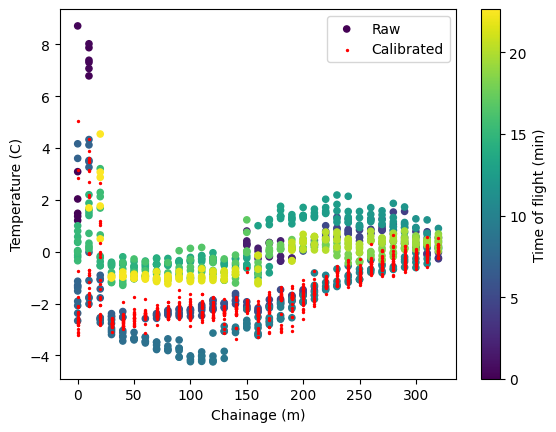

In [5]:
#plot scatter x vs y with color z
import matplotlib.pyplot as plt

first_date = min(z["uncal"]).timestamp()
timestamps = [(date.timestamp() - first_date) for date in z["uncal"]]
#convert timestamps to minutes
timestamps = [timestamp/60 for timestamp in timestamps]
cplot = plt.scatter(x["uncal"], y["uncal"], c=timestamps, cmap="viridis", s=20, label="Raw")
plt.scatter([x["cal"]], y["cal"], c="red", s=2, label="Calibrated")
plt.xlabel("Chainage (m)")
plt.ylabel("Temperature (C)")
plt.legend()
#set color label as time
cbar = plt.colorbar(cplot, label="Time of flight (min)")
#plt.ylim(4,14)
plt.show()

In [6]:
#plot gdf on leafmap
import leafmap
m = leafmap.Map()
names = [ name for name in os.listdir(geotiff_cal_dir) if name.endswith(".tiff") ]
for name in names[::10]:
    m.add_raster(f"{geotiff_cal_dir}/{name}", layer_name=name)
m.add_gdf(river_pts_gdf, layer_name="probes", fill_colors=['red'])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…